<a href="https://colab.research.google.com/github/geotrush/Neural-Network-Zoo/blob/main/PyTorch/Image%2BVideo%2BAudio-Synthesis/Style-Transfer/Fast%20Neural%20Style%20Transfer%20with%20AdaIN.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

# Fast Neural Style Transfer with AdaIN
---------------------------------------
### Paper: [Arbitrary Style Transfer in Real-time with Adaptive Instance Normalization (Huang & Belongie., 2017)](https://arxiv.org/pdf/1703.06868.pdf)

### GitHub: [PyTorch Implementation of Fast Neural Style Transfer with AdaIN (Huang & Belongie., 2017)](https://github.com/xunhuang1995/AdaIN-style)

- Download pretrained weights & biases and convert model files from `.t7` to `.pth`

In [ ]:
%%bash

pip install torch==0.4.1

wget https://s3.amazonaws.com/xunhuang-public/adain/decoder.t7
wget https://s3.amazonaws.com/xunhuang-public/adain/vgg_normalised.t7

git clone https://github.com/naoto0804/pytorch-AdaIN.git
python pytorch-AdaIN/torch_to_pytorch.py -m decoder.t7
python pytorch-AdaIN/torch_to_pytorch.py -m vgg_normalised.t7

pip install --force-reinstall torch torchvision pillow==7.0.0

- Import libraries

In [ ]:
# Notebook display
from PIL import Image
from tqdm.notebook import tqdm
from google.colab import files
import matplotlib.pyplot as plt
from IPython.display import clear_output

# PyTorch
import torch
from torch.optim import Adam
import torch.nn.functional as F
from torchvision import transforms
from torch.nn import Module, Sequential, ReflectionPad2d, Conv2d

- Define constants and image processing functions

In [ ]:
# Image size
SIZE = 1280

# Determine device
DEVICE = torch.device('cuda' if torch.cuda.is_available() else 'cpu')

# Pre-processing
def prep(image, size=SIZE, to_tensor=False, device=DEVICE):
    resize = transforms.Compose([transforms.Resize(size, Image.LANCZOS),
                                 transforms.CenterCrop(size)])
    image = resize(image.convert('RGB'))
    if to_tensor:
        return transforms.ToTensor()(image).unsqueeze(0).to(device)
    else:
        return image

# Post-processing
def post(tensor):
    return transforms.ToPILImage()(tensor.detach().cpu().squeeze(0).clamp_(0, 1))

# Draw content, style and output images
def draw(input, content_image, style_image):
    output = post(input)

    clear_output(wait=True)
    plt.figure(figsize=(18, 6))

    ax1 = plt.subplot(1, 3, 1)
    ax1.imshow(prep(content_image))
    ax1.axis('off')
    ax1.set_title('Content Image')

    ax2 = plt.subplot(1, 3, 2)
    ax2.imshow(prep(style_image))
    ax2.axis('off')
    ax2.set_title('Style Image')

    ax3 = plt.subplot(1, 3, 3)
    ax3.imshow(output)
    ax3.axis('off')
    ax3.set_title('Output Image')

    plt.show()
    return output

- Upload a single pair (if testing) or any number of content and style images (if training)

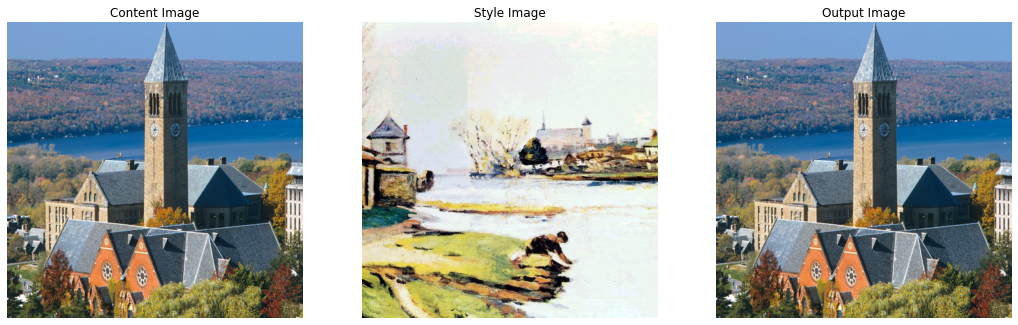

In [ ]:
# Manually upload the images
files.upload()

# Or download the ones that don't require training
!wget https://raw.githubusercontent.com/xunhuang1995/AdaIN-style/master/input/content/cornell.jpg
!wget https://raw.githubusercontent.com/xunhuang1995/AdaIN-style/master/input/style/the_resevoir_at_poitiers.jpg

# Open and prepare images (if more than a single pair, then also create an iterator)
content_image, style_image = Image.open('cornell.jpg'), Image.open('the_resevoir_at_poitiers.jpg')
content, style = prep(content_image, to_tensor=True), prep(style_image, to_tensor=True)

# Display images
_ = draw(content, content_image, style_image)

- Define AdaIN functions

In [ ]:
def calculate_mean_std(features, eps=1e-5):
    size = features.size()
    N, C = size[:2]
    features_var = features.view(N, C, -1).var(dim=2) + eps
    features_std = features_var.sqrt().view(N, C, 1, 1)
    features_mean = features.view(N, C, -1).mean(dim=2).view(N, C, 1, 1)
    return features_mean, features_std

def calculate_flatten_mean_std(features):
    features_flatten = features.view(3, -1)
    mean = features_flatten.mean(dim=-1, keepdim=True)
    std = features_flatten.std(dim=-1, keepdim=True)
    return features_flatten, mean, std

def matrix_sqrt(x):
    U, D, V = torch.svd(x)
    return torch.mm(torch.mm(U, D.pow(0.5).diag()), V.t())

def coral(source, target):
    source, source_mean, source_std = calculate_flatten_mean_std(source)
    source_norm = (source - source_mean.expand_as(source)) / source_std.expand_as(source)
    source_cov_eye = torch.mm(source_norm, source_norm.t()) + torch.eye(3)

    target, target_mean, target_std = calculate_flatten_mean_std(target)
    target_norm = (target - target_mean.expand_as(target)) / target_std.expand_as(target)
    target_cov_eye = torch.mm(target_norm, target_norm.t()) + torch.eye(3)

    source_norm_transfer = torch.mm(matrix_sqrt(target_cov_eye),
                                      torch.mm(torch.inverse(matrix_sqrt(source_cov_eye)), source_norm))
    
    source_transfer = source_norm_transfer * target_std.expand_as(source_norm) + target_mean.expand_as(source_norm)

    return source_transfer.view(source.size())

- Define Encoder-Decoder architecture with AdaIN

In [ ]:
class ConvBlock(Module):
    def __init__(self, in_channels, out_channels, kernel_size, activation=True, max_pool=False, upsample=False):
        super().__init__()

        self.activation = activation
        self.max_pool = max_pool
        self.upsample = upsample
        self.conv = Sequential(ReflectionPad2d(kernel_size // 2),
                               Conv2d(in_channels, out_channels, kernel_size))

    def forward(self, x):
        conv = self.conv(x)
        if self.activation:
            conv = F.relu(conv)
        if self.max_pool:
            conv = F.max_pool2d(conv, kernel_size=2, stride=2, ceil_mode=True)
        elif self.upsample:
            conv = F.interpolate(conv, scale_factor=2)
        return conv


class Network(Module):
    def __init__(self):
        super().__init__()

        # Encoder
        self.encoder = Sequential(Sequential(Conv2d(3, 3, kernel_size=1),
                                             ConvBlock(3, 64, kernel_size=3)),
                                  Sequential(ConvBlock(64, 64, kernel_size=3, max_pool=True),
                                             ConvBlock(64, 128, kernel_size=3)),
                                  Sequential(ConvBlock(128, 128, kernel_size=3, max_pool=True),
                                             ConvBlock(128, 256, kernel_size=3)),
                                  Sequential(ConvBlock(256, 256, kernel_size=3),
                                             ConvBlock(256, 256, kernel_size=3),
                                             ConvBlock(256, 256, kernel_size=3, max_pool=True),
                                             ConvBlock(256, 512, kernel_size=3)))
        
        # Decoder
        self.decoder = Sequential(ConvBlock(512, 256, kernel_size=3, upsample=True),
                                  ConvBlock(256, 256, kernel_size=3),
                                  ConvBlock(256, 256, kernel_size=3),
                                  ConvBlock(256, 256, kernel_size=3),
                                  ConvBlock(256, 128, kernel_size=3, upsample=True),
                                  ConvBlock(128, 128, kernel_size=3),
                                  ConvBlock(128, 64, kernel_size=3, upsample=True),
                                  ConvBlock(64, 64, kernel_size=3),
                                  ConvBlock(64, 3, kernel_size=3, activation=False))

        # Freeze Encoder Parameters
        for parameter in self.encoder.parameters():
            parameter.requires_grad = False

    # Get Features From All Encoder Layers
    def get_all_encoder_features(self, input):
        features = [input]
        for i in range(4):
            features.append(self.encoder[i](features[-1]))
        return features[1:]
    
    # Apply Adaptive Instance Normalization
    def adain(self, content_feats, style_feats):
        size = content_feats.size()
        style_mean, style_std = calculate_mean_std(style_feats)
        content_mean, content_std = calculate_mean_std(content_feats)
        normalized_feats = (content_feats - content_mean.expand(size)) / content_std.expand(size)
        return normalized_feats * style_std.expand(size) + style_mean.expand(size)

    # Calculate Content Loss
    def content_loss(self, input, target):
        return F.mse_loss(input, target)

    # Calculate Style Loss
    def style_loss(self, input, target):
        input_mean, input_std = calculate_mean_std(input)
        target_mean, target_std = calculate_mean_std(target)
        return F.mse_loss(input_mean, target_mean) + F.mse_loss(input_std, target_std)

    def forward(self, content, style, alpha=1):
        assert 0 <= alpha <= 1
        content_feats = self.encoder(content)
        style_feats = self.get_all_encoder_features(style)
        stylized_feats = self.adain(content_feats, style_feats[-1])
        stylized_feats = alpha * stylized_feats + (1 - alpha) * content_feats

        generated_stylization = self.decoder(stylized_feats)
        generated_stylization_feats = self.get_all_encoder_features(generated_stylization)

        content_loss = self.content_loss(generated_stylization_feats[-1], stylized_feats)
        style_loss = self.style_loss(generated_stylization_feats[0], style_feats[0])
        for i in range(1, 4):
            style_loss += self.style_loss(generated_stylization_feats[i], style_feats[i])
        return content_loss, style_loss

- Load pre-trained weights & biases

In [ ]:
network = Network().to(DEVICE)

state = network.state_dict()

new_encoder_state_values = iter(torch.load('vgg_normalised.pth').values())
new_decoder_state_values = iter(torch.load('decoder.pth').values())

for i, key in enumerate(state):
    if key.startswith('encoder'):
        state[key] = next(new_encoder_state_values)
    elif key.startswith('decoder'):
        state[key] = next(new_decoder_state_values)

network.load_state_dict(state)

### Training stage (you should train on multiple content and style images at once)

- Train Network on the chosen content and style images

In [ ]:
%%time

def adjust_learning_rate(optimizer, lr, lr_decay, iteration_count):
    lr /= (1 + lr_decay * iteration_count)
    for param_group in optimizer.param_groups:
        param_group['lr'] = lr

def train(network, content, style, lr=1e-4, lr_decay=5e-5, content_weight=1, style_weight=10, iterations=30):
    optimizer = Adam(network.decoder.parameters(), lr=lr)
    for iter in tqdm(range(iterations)):
        optimizer.zero_grad()
        adjust_learning_rate(optimizer, lr, lr_decay, iteration_count=iter)
        content_loss, style_loss = network(content, style)
        total_loss = content_weight * content_loss + style_weight * style_loss
        total_loss.backward()
        optimizer.step()
    torch.save(network.state_dict(), 'network.pth')

# Run
train(network, content, style)

### Inference step

- Transfer style

In [ ]:
%%time

def transfer_style(network, content, style, alpha=1):
    assert 0 <= alpha <= 1
    content_feats = network.encoder(content)
    style_feats = network.encoder(style)

    network.eval()
    with torch.no_grad():
        stylized_feats = network.adain(content_feats, style_feats)
        stylized_feats = stylized_feats * alpha + content_feats * (1 - alpha)
        output = draw(network.decoder(stylized_feats), content_image, style_image)
    return output

# Run
network.load_state_dict(torch.load('network.pth'))
output = transfer_style(network, content, style)

- Save and download output

In [ ]:
output.save('output.png')
files.download('output.png')